<span style="color: #60B5FC; font-weight: bold; font-size: 24px;">03 Best Model Training</span>

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Libraries</span>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
import joblib



<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Dataframe</span>

In [3]:
df = pd.read_csv('/Users/anagilabert/repos/students_exam_scores/data/Expanded_data_with_more_features.csv', index_col=0)
df = df.drop(['ReadingScore', 'WritingScore'], axis=1)

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Format review</span>

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Target column</span>

In [5]:
target_column = 'mathscore'

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Split train and test</span>

In [6]:
def split_train_test(X, y):
    # Split the data into a training set (60%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

    # Split the remaining data into a validation set (20%) and a test set (20%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    df_train = pd.concat([X_train, y_train], axis=1)
    df_val = pd.concat([X_val, y_val], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)

    return X_train, y_train, X_test, y_test, X_val, y_val, df_train, df_test, df_val

X = df.drop(columns=[target_column])
y = df[target_column]

X_train, y_train, X_test, y_test, X_val, y_val, df_train, df_test, df_val = split_train_test(X, y)

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Train XGB Regressor Model</span>

In [7]:
# Automatically identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).columns.tolist()
numerical_columns.remove(target_column)

# Create transformers for specific categorical and numerical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# Wrap the custom transformer using FunctionTransformer

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_columns),
        ('numerical', numerical_transformer, numerical_columns),
    ],
    remainder='passthrough'
)

# Step 3: Machine Learning Model
regressor = XGBRegressor()

# Create the pipeline with imputer to handle missing values
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', regressor)
])

def split_train_test(X, y):
    # Split the data into a training set (60%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

    # Split the remaining data into a validation set (20%) and a test set (20%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    df_train = pd.concat([X_train, y_train], axis=1)
    df_val = pd.concat([X_val, y_val], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)

    return X_train, y_train, X_test, y_test, X_val, y_val, df_train, df_test, df_val

X = df.drop(columns=[target_column])
y = df[target_column]

X_train, y_train, X_test, y_test, X_val, y_val, df_train, df_test, df_val = split_train_test(X, y)

param_dist = {
    'regressor__n_estimators': np.arange(100, 1000, 100),  # Número de árboles en el modelo
    'regressor__learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'regressor__max_depth': np.arange(3, 10, 1),  # Profundidad máxima del árbol
    'regressor__min_child_weight': np.arange(1, 6, 1),  # Peso mínimo de una hoja
    'regressor__gamma': [0, 0.1, 0.2],  # Parámetro gamma
    'regressor__subsample': [0.8, 0.9, 1.0],  # Submuestra de datos para entrenar cada árbol
}

# Crea un objeto RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)


# Ajusta el modelo con búsqueda de hiperparámetros aleatoria
random_search.fit(X_train, y_train)

# Encuentra los mejores hiperparámetros
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Utiliza el mejor modelo para hacer predicciones
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)


Mejores hiperparámetros: {'regressor__subsample': 0.9, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 3, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0}


In [8]:
# Predict using the pipeline
y_test_pred = best_model.predict(X_test)
y_val_pred = best_model.predict(X_val)

# Calculate MAE for the test and validation datasets
test_mae = mean_absolute_error(y_test, y_test_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

# Calculate MSE for the test and validation datasets
test_mse = mean_squared_error(y_test, y_test_pred)
val_mse = mean_squared_error(y_val, y_val_pred)

# Calculate RMSE for the test and validation datasets
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

# Calculate R-squared (R^2) for the test and validation datasets
test_r2 = r2_score(y_test, y_test_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Print the regression metrics
print("Test MAE:", test_mae)
print("Validation MAE:", val_mae)
print("\nTest MSE:", test_mse)
print("Validation MSE:", val_mse)
print("\nTest RMSE:", test_rmse)
print("Validation RMSE:", val_rmse)
print("\nTest R-squared:", test_r2)
print("Validation R-squared:", val_r2)


Test MAE: 10.68221543496148
Validation MAE: 10.509042406829156

Test MSE: 173.04512911288916
Validation MSE: 167.50819380539852

Test RMSE: 13.154661877558432
Validation RMSE: 12.942495655993033

Test R-squared: 0.2699298834969692
Validation R-squared: 0.286481580010275


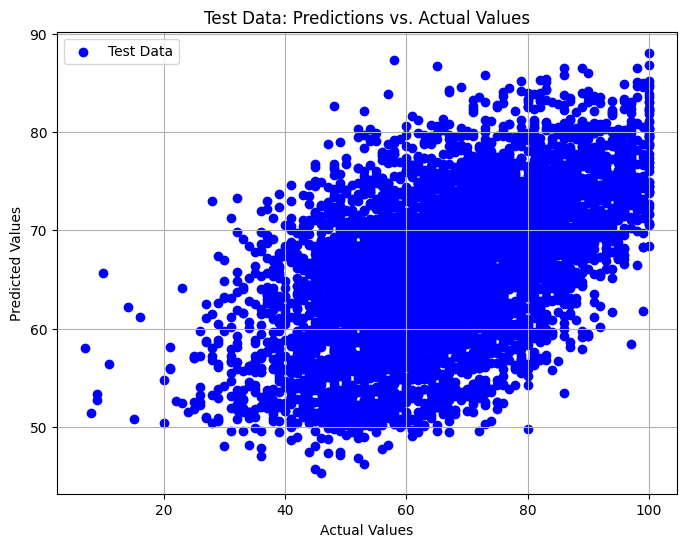

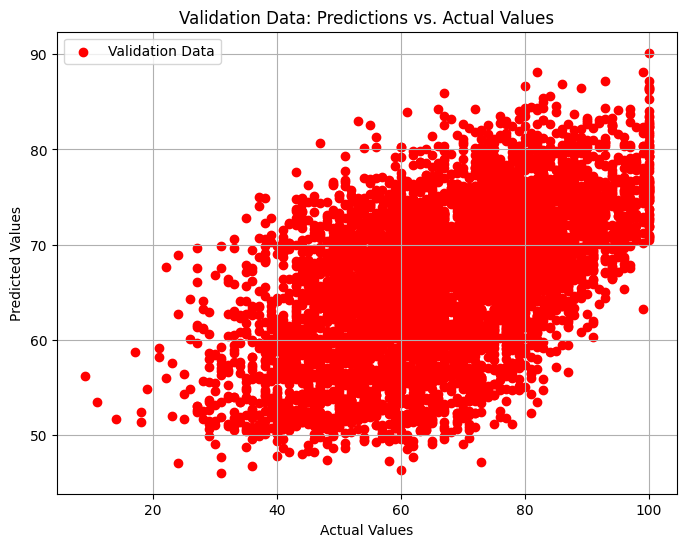

In [9]:
# Create a scatter plot for the test dataset
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Data: Predictions vs. Actual Values')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Create a scatter plot for the validation dataset
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, color='red', label='Validation Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Validation Data: Predictions vs. Actual Values')
plt.legend(loc='best')
plt.grid(True)
plt.show()

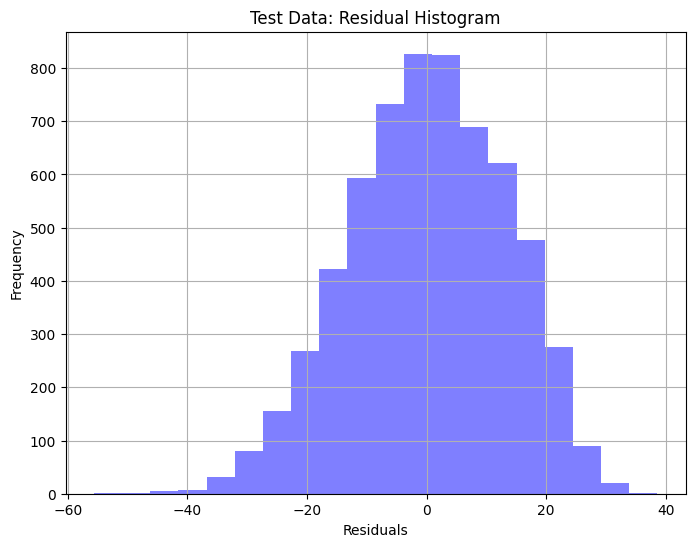

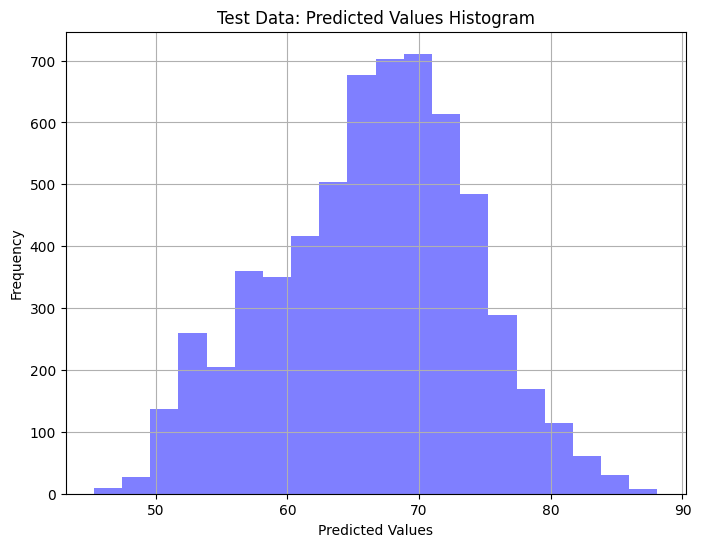

In [10]:
# Create a histogram of residuals for test data
plt.figure(figsize=(8, 6))
plt.hist(y_test - y_test_pred, bins=20, color='blue', alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Test Data: Residual Histogram')
plt.grid(True)
plt.show()


# Create a histogram of predicted values for test data
plt.figure(figsize=(8, 6))
plt.hist(y_test_pred, bins=20, color='blue', alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Test Data: Predicted Values Histogram')
plt.grid(True)
plt.show()

<span style="color: #AC1555; font-weight: bold; font-size: 18px;">Save Model</span>

In [14]:
joblib.dump(best_model, '../src/ml_models/best_model.pkl')

['../src/ml_models/best_model.pkl']

In [16]:
X_test.head(1).to_dict()

{'gender': {932: 'female'},
 'ethnicgroup': {932: 'group A'},
 'parenteduc': {932: 'some college'},
 'lunchtype': {932: 'free/reduced'},
 'testprep': {932: 'none'},
 'parentmaritalstatus': {932: 'single'},
 'practicesport': {932: 'never'},
 'isfirstchild': {932: 'no'},
 'nrsiblings': {932: 1.0},
 'transportmeans': {932: 'school_bus'},
 'wklystudyhours': {932: '> 10'}}